In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, silhouette_score, silhouette_samples
import matplotlib.cm as cm

sns.set(style="whitegrid")

In [2]:
file_path = 'netflix-rotten-tomatoes-metacritic-imdb.csv'

try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    df = pd.DataFrame({
        'Series or Movie': ['Movie']*1000 + ['Series']*300,
        'Hidden Gem Score': np.random.rand(1300) * 10,
        'IMDb Score': np.random.rand(1300) * 10,
        'IMDb Votes': np.random.randint(100, 100000, 1300),
        'Runtime': np.random.choice(['< 30 minutes', '1-2 hour'], 1300),
        'View Rating': np.random.choice(['R', 'PG-13', 'TV-MA'], 1300)
    })

cols_to_drop = [
    'Rotten Tomatoes Score', 'Metacritic Score', 'Boxoffice', 'Production House',
    'Awards Received', 'Awards Nominated For', 'TMDb Trailer', 'Trailer Site',
    'Netflix Link', 'IMDb Link', 'Poster', 'Image', 'Summary', 'Title',
    'Release Date', 'Netflix Release Date', 'Tags', 'Genre', 'Languages', 
    'Director', 'Writer', 'Actors', 'Country Availability'
]

existing_cols = [c for c in cols_to_drop if c in df.columns]
df_clean = df.drop(columns=existing_cols)

In [6]:
y_true = df_clean['Series or Movie'].map({'Movie': 0, 'Series': 1}).fillna(0)
X_raw = df_clean.drop(columns=['Series or Movie'])

numeric_features = ['Hidden Gem Score', 'IMDb Score', 'IMDb Votes']
categorical_features = ['View Rating', 'Runtime']

numeric_features = [c for c in numeric_features if c in X_raw.columns]
categorical_features = [c for c in categorical_features if c in X_raw.columns]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_scaled = preprocessor.fit_transform(X_raw)

if hasattr(X_scaled, 'toarray'):
    X_scaled = X_scaled.toarray()

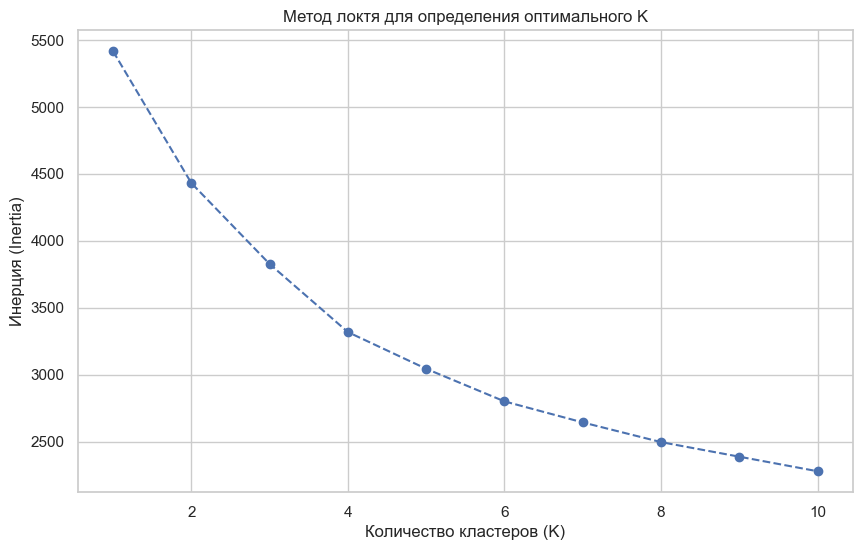

In [8]:
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.xlabel('Количество кластеров (K)')
plt.ylabel('Инерция (Inertia)')
plt.title('Метод локтя для определения оптимального K')
plt.show()

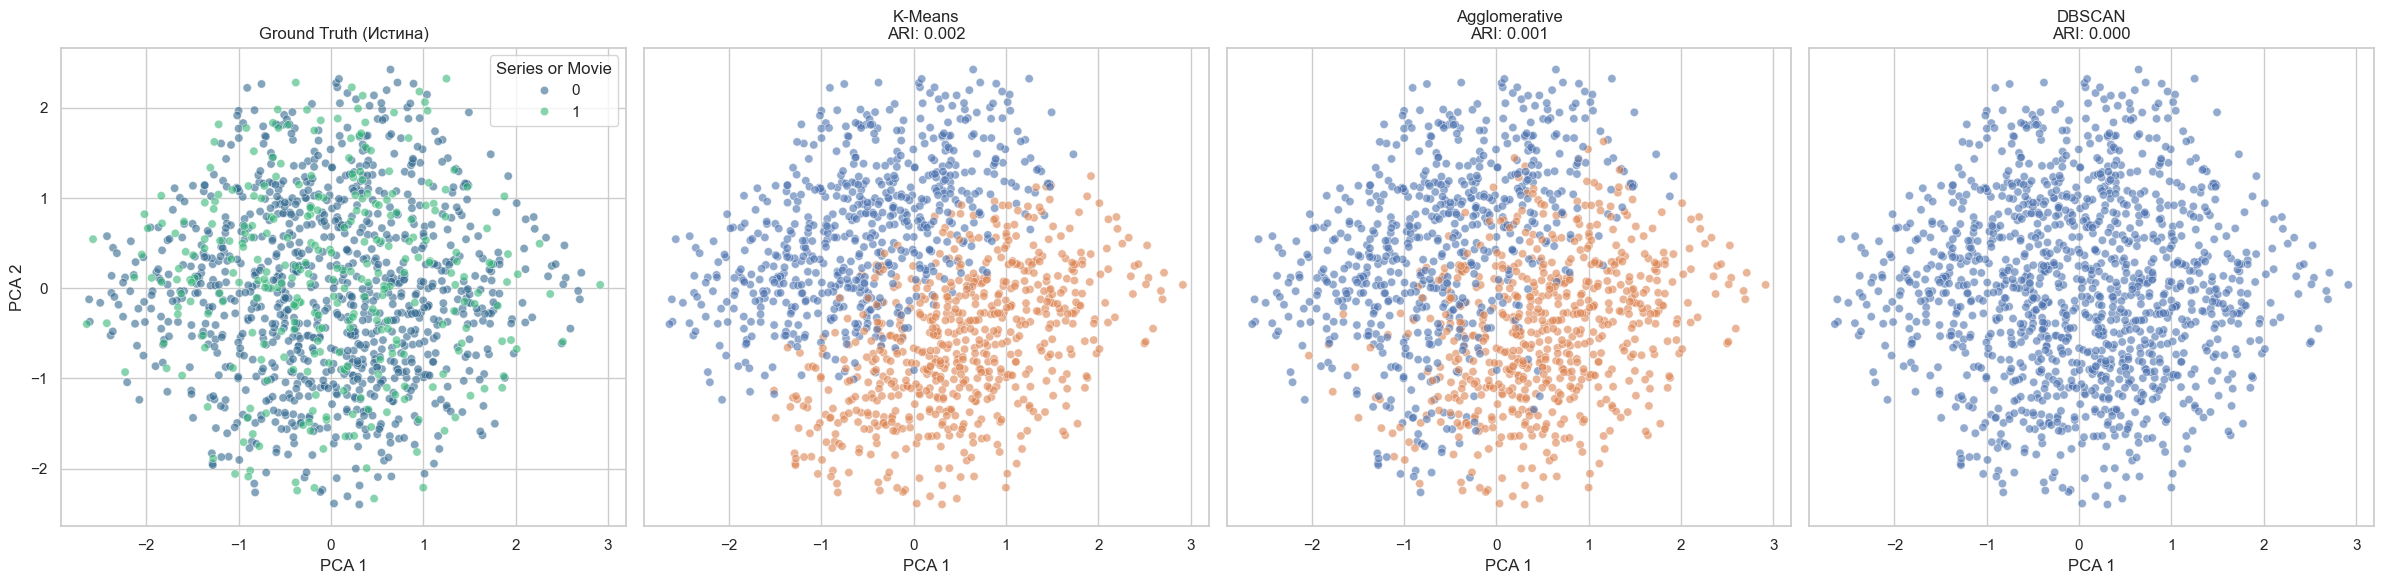

In [10]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

models = {
    "K-Means": KMeans(n_clusters=2, random_state=42, n_init=10),
    "Agglomerative": AgglomerativeClustering(n_clusters=2),
    "DBSCAN": DBSCAN(eps=2.0, min_samples=5) 
}

fig, axes = plt.subplots(1, 4, figsize=(24, 6))

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_true, palette='viridis', alpha=0.6, ax=axes[0])
axes[0].set_title("Ground Truth (Истина)")
axes[0].set_xlabel("PCA 1")
axes[0].set_ylabel("PCA 2")

results = {}

for i, (name, model) in enumerate(models.items(), 1):
    labels = model.fit_predict(X_scaled)
    score = adjusted_rand_score(y_true, labels)
    results[name] = score
    
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='deep', alpha=0.6, ax=axes[i], legend=False)
    axes[i].set_title(f"{name}\nARI: {score:.3f}")
    axes[i].set_xlabel("PCA 1")
    axes[i].set_yticks([])

plt.tight_layout()
plt.show()

kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)
silhouette_avg = silhouette_score(X_scaled, cluster_labels)
sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)

plt.figure(figsize=(10, 6))
y_lower = 10

for i in range(2):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = cm.nipy_spectral(float(i) / 2)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.title("Силуэтный график для K-Means (K=2)")
plt.xlabel("Коэффициент силуэта")
plt.ylabel("Метка кластера")
plt.show()

print("ARI Scores:", results)

Cтруктура данных о фильмах и сериалах не имеет естественного разделения на два кластера по имеющимся признакам. Для их различения необходим учитель (целевая метка), либо специфический признак (например, длительность), который нужно использовать не для поиска расстояний, а как жесткий порог.